In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.market_env import MarketEnvironment
from src.instruments import EuropeanOption
from src.hedging_engine import PortfolioManager, HedgingSimulation
# Styling for professional charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

### ==========================================
### EXPERIMENT 1: The "Black Swan" Crash
####  "Spot down 40% while vol triples"
### ==========================================



### 1. Define the Scenarios 


In [16]:
# 1. Define the Scenarios 

# 20 Trading Days (approx 1 month)
# ypothetical starting date 
start_date = '2026-01-01'
env = MarketEnvironment(spot_start=100, vol_start=0.20, sofr_start=0.04, spread_start=0.01)

# Generate a catastrophic crash
df_crash = env.simulate_scenario(
    start_date=start_date, 
    num_days=20,
    spot_ret=-0.40,      # Market crashes 40%
    vol_mult=3.0,        # Volatility Triples (20% -> 60%+)
    d_sofr=-0.0100,      # Fed cuts rates 100bps
    d_spread=0.0200      # Credit Spreads blow out 200bps
)

### 2. Setup The Portfolio (Pure Equity Option View)
##### We are Short 10,000 ATM Puts. This is **"Short Gamma"** and **"Short Vega"**. 

In [17]:
# 2. Setup The Portfolio (Pure Equity Option View)
# We are Short 10,000 ATM Puts. This is "Short Gamma" and "Short Vega".
# initialize the portfolio 
pm_crash = PortfolioManager()
# Expires in 1 Year
liability_option = EuropeanOption(strike=100, expiry_date='2027-01-01', option_type='put')
pm_crash.add_position(liability_option, quantity=-10000)

### 3. Run Simulation: Delta Hedged Only


In [18]:
# 3. Run Simulation: Delta Hedged Only
# We use stock to stay Delta Neutral, but we ignore Gamma/Vega 
# i.e. no gamma_hedge_inst or vega_hedge_inst is fed into the class
sim_crash = HedgingSimulation(pm_crash, df_crash)
res_crash = sim_crash.run()

### 4. Visualize the "Gamma Bleed"
##### Short Gamma means we become **increasingly Long** in an asset when it is depreciating in value. To delta-hedge, we short the stock. Bing short Gamma means we become LOng Delta following a gap down. To remain delta-hedged, we would need to increase our short position in the underlying, leading to P&L bleed. 

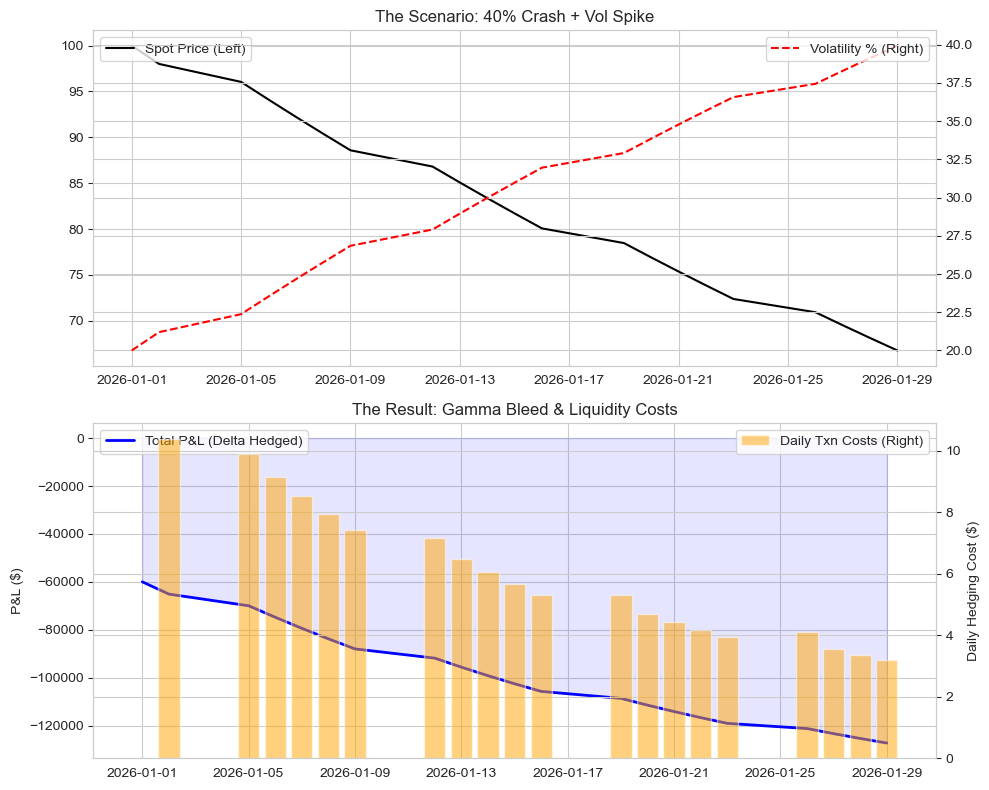

In [19]:
# 4. Visualize the "Gamma Bleed"
# Even though we hedge Delta daily, we lose money because the market moves faster than we can trade.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Top Plot: Market Variables
ax[0].plot(res_crash.index, res_crash['spot'], color='black', label='Spot Price (Left)')
ax0_twin = ax[0].twinx()
ax0_twin.plot(res_crash.index, df_crash['vol'] * 100, color='red', linestyle='--', label='Volatility % (Right)')
ax[0].set_title("The Scenario: 40% Crash + Vol Spike")
ax[0].legend(loc='upper left')
ax0_twin.legend(loc='upper right')

# Bottom Plot: P&L Components
# Total P&L vs Transaction Costs
ax[1].plot(res_crash.index, res_crash['total_pnl'], label='Total P&L (Delta Hedged)', color='blue', linewidth=2)
ax[1].fill_between(res_crash.index, res_crash['total_pnl'], 0, alpha=0.1, color='blue')
ax[1].set_title("The Result: Gamma Bleed & Liquidity Costs")
ax[1].set_ylabel("P&L ($)")

# Highlight the cost of liquidity
ax1_twin = ax[1].twinx()
ax1_twin.bar(res_crash.index, res_crash['txn_costs'], color='orange', alpha=0.5, label='Daily Txn Costs (Right)')
ax1_twin.set_ylabel("Daily Hedging Cost ($)")

ax[1].legend(loc='upper left')
ax1_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

### ==========================================
### EXPERIMENT 2: The "Maturity Mismatch"
#### "What if your short put is 5y, but your (long put) hedge is 1y?"
##### -> Hedge is 5Y. Sine Vega is proportional to sqrt(T), Hedge's vega is much lower than the 1Y position. So to match the position's Vega, we need a very large number of contracts. 
### ==========================================

### 1. Setup Portfolio: Short 5-Year Put


In [20]:
# 1. Setup Portfolio: Short 5-Year Put

pm_mismatch = PortfolioManager()
long_dated_liability = EuropeanOption(strike=100, expiry_date='2031-01-01', option_type='put') # 5 Years out
pm_mismatch.add_position(long_dated_liability, -10000)

### 2. Setup Hedge Instrument: Long 1-Year Put!


In [21]:
# 2. Setup Hedge instrument: Long 1-Year Put
# Hedging the Veg of a 5y option using a 1y option
short_dated_hedge = EuropeanOption(strike=100, expiry_date='2027-01-01', option_type='put') # 1 Year out

### 3. Run Simulation with Vega Hedging Enabled


In [22]:
# 3. Run Simulation with Vega Hedging Enabled
# We will buy enough 1y Puts to neutralize the Vega of the 5y Puts
sim_mismatch = HedgingSimulation(
    portfolio=pm_mismatch, 
    market_scenario_df=df_crash, # Use the same crash scenario
    vega_hedge_inst=short_dated_hedge
)
res_mismatch = sim_mismatch.run()

### 4. Visualize the Basis Risk


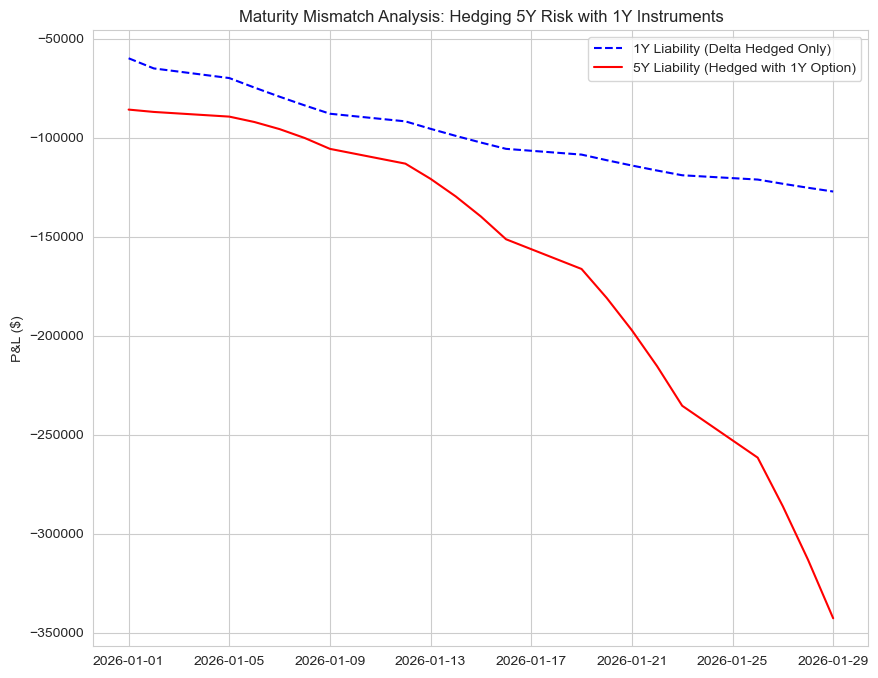

Final P&L (1Y Liability, Delta Only): $-127,247.18
Final P&L (5Y Liability, 1Y Vega Hedge): $-342,673.08
The 5Y option moves less (lower Gamma) than the 1Y option.
However, the 'vega_hedge_pos' below. We had to buy a huge amount of 1Y options, because of the lower vega of the hedge instrument

specifically we had to buy 31,151.93 positions in the 1Y put by the end of the shock period


                 spot  vega_hedge_pos      total_pnl
date                                                
2026-01-21  75.364194    26275.506464 -197278.634301
2026-01-22  73.856910    26996.887503 -215378.000360
2026-01-23  72.379772    27741.607579 -235397.019012
2026-01-26  70.932177    28651.568403 -261577.123807
2026-01-27  69.513533    29456.642254 -286148.713367
2026-01-28  68.123262    30289.554119 -313121.998997
2026-01-29  66.760797    31151.934887 -342673.081592


In [23]:
# 4. Visualize the Basis Risk
plt.figure(figsize=(10, 8))

# Compare P&L of simply Delta Hedging (Red) vs trying to Hedge Vega with 1y (Green)
plt.plot(res_crash.index, res_crash['total_pnl'], label='1Y Liability (Delta Hedged Only)', color='blue', linestyle='--')
plt.plot(res_mismatch.index, res_mismatch['total_pnl'], label='5Y Liability (Hedged with 1Y Option)', color='red')

plt.title("Maturity Mismatch Analysis: Hedging 5Y Risk with 1Y Instruments")
plt.ylabel("P&L ($)")
plt.legend()
plt.grid(True)
plt.show()


print(f"Final P&L (1Y Liability, Delta Only): ${res_crash['total_pnl'].iloc[-1]:,.2f}")
print(f"Final P&L (5Y Liability, 1Y Vega Hedge): ${res_mismatch['total_pnl'].iloc[-1]:,.2f}")
print("The 5Y option moves less (lower Gamma) than the 1Y option.")
print("However, the 'vega_hedge_pos' below. We had to buy a huge amount of 1Y options, because of the lower vega of the hedge instrument")
print(f"\nspecifically we had to buy {res_mismatch['vega_hedge_pos'].iloc[-1]:,.2f} positions in the 1Y put by the end of the shock period")
print("\n")
print(res_mismatch[['spot', 'vega_hedge_pos', 'total_pnl']].tail(7))

##### The problem with the above hedge is that, we tried to fit a **"U"** (5-year put, Low Gamma)  into a **"V"** (1-year put, High Gamma). We match the bottom of the "U" and the "V" when we Delta-hedge. 
##### ATM, delta of both options is close (e.g. 1Y Put: Delta = -0.5, 5Y Put: Delta = -0.4).  The hedging engine balances our delta. Gamma is bell-shaped and peaks ATM. The lower TTM, the higher the peak. 
##### **Since 1Y put has lower time to maturity, it has higher Gamma. This means its delta changes much more aggresively with changes in the stock price. Starting from our Delta-neutral position, we become much more long in the stock when it gaps down from the shock.** 

#### To show that the source of the problem is Gamma and not Vega, below, I use an alternative example. Assume we have a short 1Y Put position and we hedge it with 5Y Long Put. we observe that since "buckets" do not match, same problem exists, albeit to a slightly lesser extent.

### ==========================================
### EXPERIMENT 3: The "Reverse" Mismatch (**The Lazy Hedge**)
### Hedging a 1Y Liability (Higher Gamma, Lower Vega) with a 5Y Asset (Lower Gamma, Higher Vega)
### ==========================================

In [24]:
print("--- Running Experiment 3: Reverse Mismatch (1Y vs 5Y) ---")

sim_start_date = '2026-01-01'

# 1. Setup Liability: Short 1-Year Put (High Gamma Risk)
pm_reverse = PortfolioManager()
short_dated_liability = EuropeanOption(strike=100, expiry_date='2027-01-01', option_type='put') 
pm_reverse.add_position(short_dated_liability, -10000)

# 2. Setup Hedge: Long 5-Year Put (High Vega, Low Gamma)
long_dated_hedge = EuropeanOption(strike=100, expiry_date='2031-01-01', option_type='put') 

# 3. Run Simulation
# The engine will buy 5Y puts to neutralize the Vega of the 1Y puts
sim_reverse = HedgingSimulation(
    portfolio=pm_reverse, 
    market_scenario_df=df_crash, # Using the same crash data
    vega_hedge_inst=long_dated_hedge
)
res_reverse = sim_reverse.run()


--- Running Experiment 3: Reverse Mismatch (1Y vs 5Y) ---


### Visualization


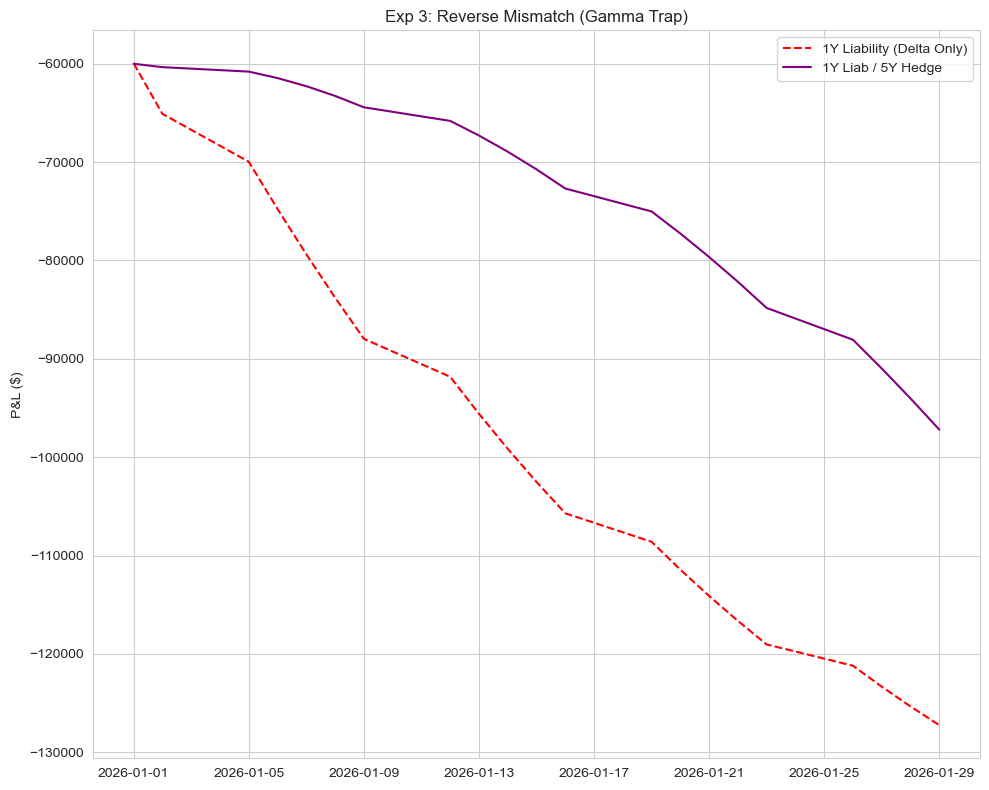

Exp 3 Final P&L (5Y Hedge): $-97,199.54
   -> Since Vega of hedge was higher (longer dated), we needed FEWER options to hedge (Vega Ratio < 1):
                 spot  vega_hedge_pos     total_pnl
date                                               
2026-01-21  75.364194     3805.825784 -79651.401784
2026-01-22  73.856910     3704.130707 -82173.943283
2026-01-23  72.379772     3604.693770 -84829.824317
2026-01-26  70.932177     3490.210330 -88064.017433
2026-01-27  69.513533     3394.820059 -90986.174753
2026-01-28  68.123262     3301.468209 -94032.371503
2026-01-29  66.760797     3210.073479 -97199.539987


In [25]:

plt.figure(figsize=(10, 8))

# Chart 1: The Reverse Mismatch (1Y vs 5Y)
plt.plot(res_crash.index, res_crash['total_pnl'], label='1Y Liability (Delta Only)', color='red', linestyle='--')
plt.plot(res_reverse.index, res_reverse['total_pnl'], label='1Y Liab / 5Y Hedge', color='purple')
plt.title("Exp 3: Reverse Mismatch (Gamma Trap)")
plt.ylabel("P&L ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ANALYSIS OUTPUT ---
print(f"Exp 3 Final P&L (5Y Hedge): ${res_reverse['total_pnl'].iloc[-1]:,.2f}")
print("   -> Since Vega of hedge was higher (longer dated), we needed FEWER options to hedge (Vega Ratio < 1):")
print(res_reverse[['spot', 'vega_hedge_pos', 'total_pnl']].tail(7))

### Why Vega Neutrality didn't save us ? 
#### We calculated that 10,000 1Y Puts ~ 4,000 5Y Puts in terms of Vega. This holds true if Price stays flat and Vol goes up; in this case, the negative P&L from change in Vol for the short Puts will be canceled out by the positive P&L effect of of the Long Puts.  
#### **But in a crash, Price Drops AND Vol goes up. The "Price Drop" part activates the Gamma mismatch violently. The 1Y Put's value explodes due to price (Gamma) much faster than the 5Y Put's value increased due to volatility (Vega).**

### ==========================================
### EXPERIMENT 4: "Proper Bucketing" (Matched Maturity)
### Liability: 1Y Put, 
### Hedge: 1Y Call (Matching the Tenor)
### ==========================================

Liability: Short 10,000 1Y Puts. (Short Gamma, Short Vega).
Hedge: Buy 1Y Calls. (Long Gamma, Long Vega).
If we bought Puts, we'd just be closing the position. Buying Calls keeps the position open but neutralizes the Volatility and Curvature risk.
Since both options expire on the same day, they react to the same volatility spike and have the same Gamma curve. 
Since we are long delta in both position **the engine will manage the Delta (Direction) by selling stock.**

--- Running Experiment 4: Proper Hedge (1Y vs 1Y) ---


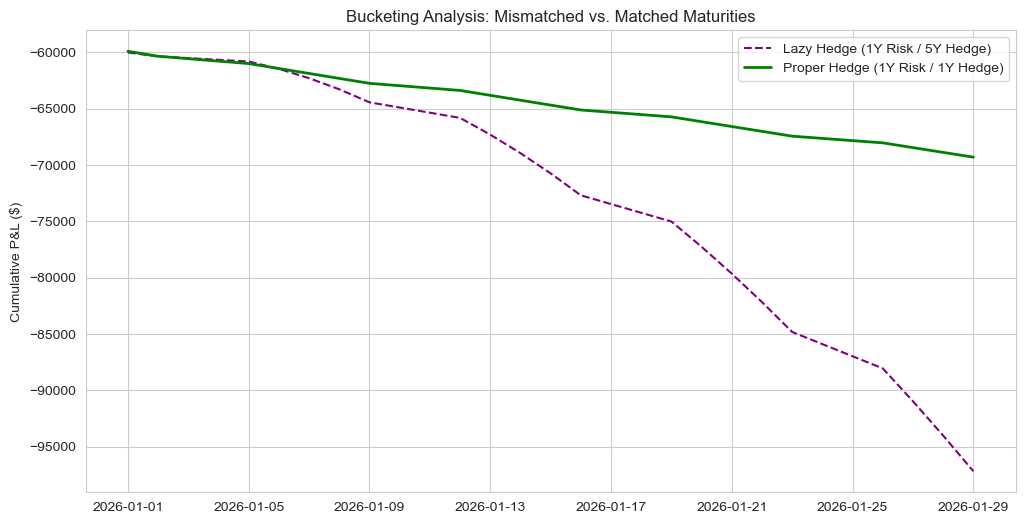

Lazy Hedge Final P&L:    $-97,200
Proper Hedge Final P&L:  $-69,301

Insight: The Matched Hedge (Green) is nearly flat.
The only losses are Transaction Costs (Bid-Ask Spread).
The Mismatched Hedge (Purple) bleeds money because the 5Y hedge failed to offset the 1Y Gamma explosion.


In [26]:
print("--- Running Experiment 4: Proper Hedge (1Y vs 1Y) ---")

# 1. Setup Liability: Short 1-Year Put (Same as before)
pm_matched = PortfolioManager()
# Expires 2027 (1 Year from start)
liability_1y = EuropeanOption(strike=100, expiry_date='2027-01-01', option_type='put')
pm_matched.add_position(liability_1y, -10000)

# 2. Setup Hedge: Long 1-Year Call
# We use a Call to hedge the Put's Vega/Gamma.
# Since they have the same maturity, their Gamma/Vega profiles are identical.
hedge_1y_call = EuropeanOption(strike=100, expiry_date='2027-01-01', option_type='call') 

# 3. Run Simulation
sim_matched = HedgingSimulation(
    portfolio=pm_matched, 
    market_scenario_df=df_crash, 
    vega_hedge_inst=hedge_1y_call
)
res_matched = sim_matched.run()

# ==========================================
# VISUALIZATION: The "Lazy" vs. "Proper" Hedge
# ==========================================

plt.figure(figsize=(12, 6))

# Plot 1: The "Lazy" Hedge (Experiment 3 - Mismatched)
# (Assuming you still have res_reverse in memory from the previous run)
plt.plot(res_reverse.index, res_reverse['total_pnl'], label='Lazy Hedge (1Y Risk / 5Y Hedge)', color='purple', linestyle='--')

# Plot 2: The "Proper" Hedge (Experiment 4 - Matched)
plt.plot(res_matched.index, res_matched['total_pnl'], label='Proper Hedge (1Y Risk / 1Y Hedge)', color='green', linewidth=2)

plt.title("Bucketing Analysis: Mismatched vs. Matched Maturities")
plt.ylabel("Cumulative P&L ($)")
plt.legend()
plt.grid(True)
plt.show()

# --- SUMMARY METRICS ---
print(f"Lazy Hedge Final P&L:    ${res_reverse['total_pnl'].iloc[-1]:,.0f}")
print(f"Proper Hedge Final P&L:  ${res_matched['total_pnl'].iloc[-1]:,.0f}")
print("\nInsight: The Matched Hedge (Green) is nearly flat.")
print("The only losses are Transaction Costs (Bid-Ask Spread).")
print("The Mismatched Hedge (Purple) bleeds money because the 5Y hedge failed to offset the 1Y Gamma explosion.")

### ==========================================
### EXPERIMENT 5: The "Repo Crisis" (Funding Stress)
### Showcasing the Preset Scenario Library
### Using a Short Call position to force Borrowing (Long Stock Hedge)
### ==========================================

--- Running Experiment 5: Repo Crisis (Funding Squeeze) ---


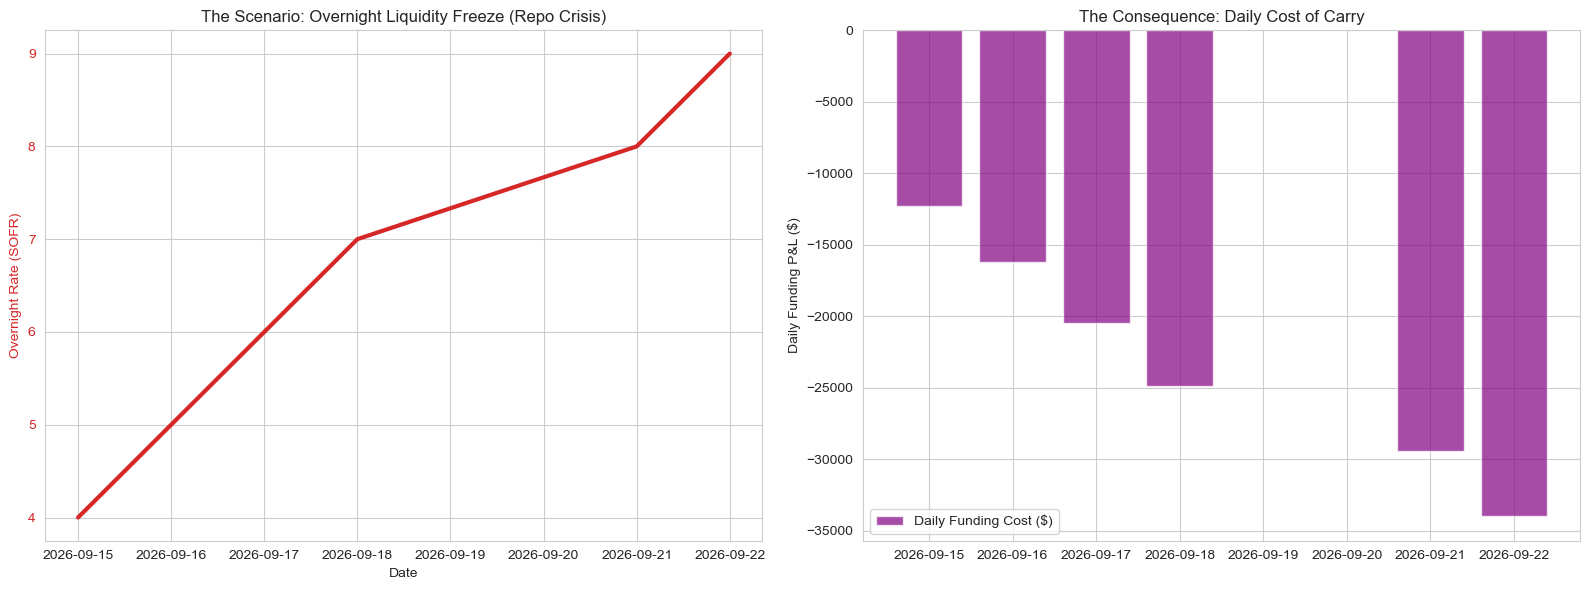

Max Overnight Rate: 9.00%
Cash Borrowed to buy Stock Hedge: $61,791,142.22
Total Funding Interest PAID (5 Days): $-137,184.36
Annualized Run Rate of Cost: $-6,914,091.62 / year


In [27]:
print("--- Running Experiment 5: Repo Crisis (Funding Squeeze) ---")

# 1. Load the Prest Scenario (5 Days of Repo Pain)
env = MarketEnvironment()
df_repo_crisis = env.repo_crisis_2019(start_date='2026-09-15', days=5)

# 2. Setup Portfolio: Short Calls (Institutional Size)
pm_repo = PortfolioManager()

# Short 1,000,000 ATM Calls (~$100M Notional Exposure)
# This forces the desk to borrow ~$60M cash to buy the stock hedge
liab = EuropeanOption(100, '2027-09-15', 'call')
pm_repo.add_position(liab, -1_000_000) 

# 3. Run Simulation
sim_repo = HedgingSimulation(pm_repo, df_repo_crisis)
res_repo = sim_repo.run()

# ==========================================
# VISUALIZATION
# ==========================================

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: The Market Shock (Rates)
color = 'tab:red'
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Overnight Rate (SOFR)', color=color)
ax[0].plot(df_repo_crisis.index, df_repo_crisis['sofr'] * 100, color=color, linewidth=3, label='SOFR %')
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].set_title("The Scenario: Overnight Liquidity Freeze (Repo Crisis)")
ax[0].grid(True)

# Plot B: The P&L Impact (Funding Cost)
ax[1].bar(res_repo.index, res_repo['funding_cost'], color='purple', alpha=0.7, label='Daily Funding Cost ($)')
ax[1].set_title("The Consequence: Daily Cost of Carry")
ax[1].set_ylabel("Daily Funding P&L ($)")
ax[1].legend()

plt.tight_layout()
plt.show()

# --- ANALYSIS OUTPUT ---
print(f"Max Overnight Rate: {df_repo_crisis['sofr'].max()*100:.2f}%")
print(f"Cash Borrowed to buy Stock Hedge: ${res_repo['stock_pos'].iloc[0] * 100:,.2f}")
print(f"Total Funding Interest PAID (5 Days): ${res_repo['funding_cost'].sum():,.2f}")
print(f"Annualized Run Rate of Cost: ${res_repo['funding_cost'].sum() * (252/5):,.2f} / year")

### ==========================================
### EXPERIMENT 6: Hedging Frequency Analysis
### Question: "How do you justify the hedging frequency?"
### Daily vs Weekly Simulation
### ==========================================

--- Running Experiment 6: Frequency (Daily vs Weekly) ---


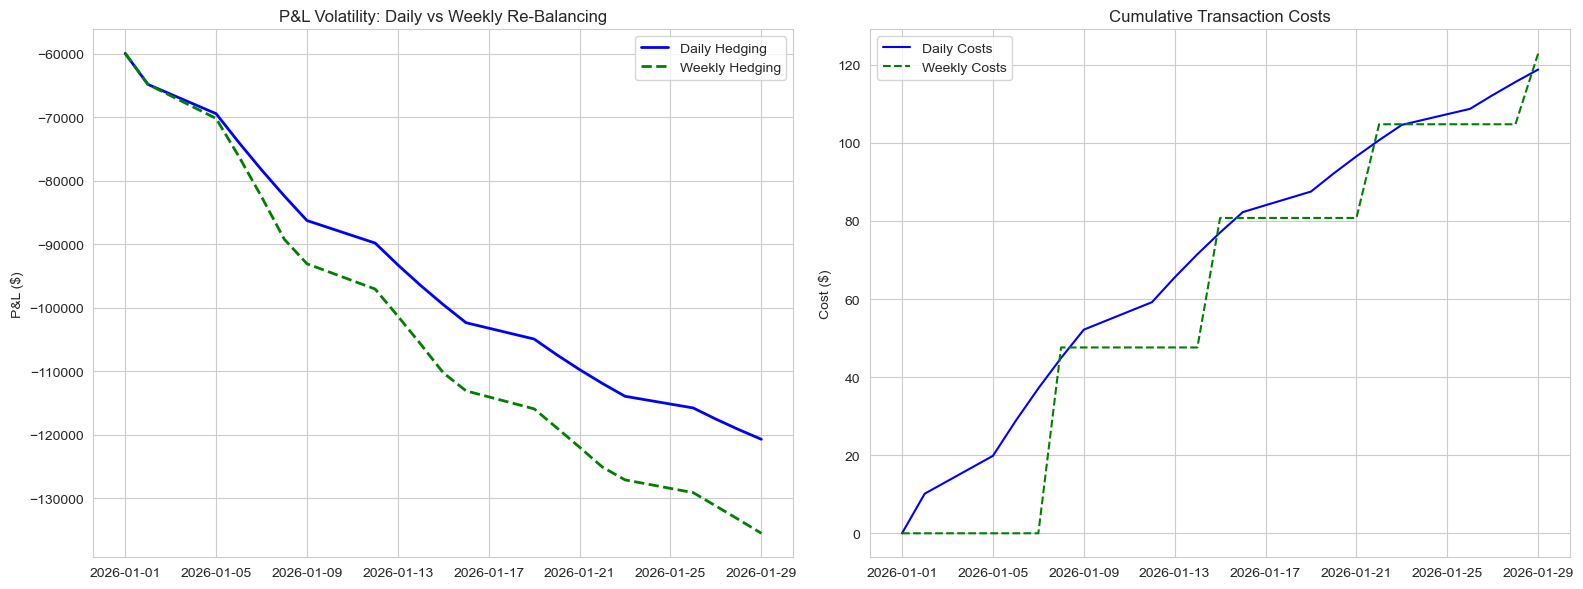

Daily Hedging | P&L: $-120,699 | Txn Costs: $119
Weekly Hedging| P&L: $-135,491 | Txn Costs: $123


In [28]:
print("--- Running Experiment 6: Frequency (Daily vs Weekly) ---")

# 1. Use the Crash Scenario (20 Days)
# 20 Days = 4 Weeks. 
env = MarketEnvironment()
df_crash = env.simulate_scenario(start_date='2026-01-01', 
                                 num_days=20, 
                                 spot_ret=-0.40, 
                                 vol_mult=3.0, 
                                 d_sofr=0, 
                                 d_spread=0.02)

# 2. Portfolio: Short 10k Puts (Standard Risk)
pm_freq = PortfolioManager()
pm_freq.add_position(EuropeanOption(100, '2027-01-01', 'put'), -10000)

# 3. Run Daily Simulation (Interval = 1)
sim_daily = HedgingSimulation(pm_freq, df_crash, rehedge_interval=1)
res_daily = sim_daily.run()

# 4. Run Weekly Simulation (Interval = 5)
# We only trade on Day 0, 5, 10, 15, 20.
sim_weekly = HedgingSimulation(pm_freq, df_crash, rehedge_interval=5)
res_weekly = sim_weekly.run()

# 5. Visualize
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Cumulative P&L
ax[0].plot(res_daily.index, res_daily['total_pnl'], label='Daily Hedging', color='blue', linewidth=2)
ax[0].plot(res_weekly.index, res_weekly['total_pnl'], label='Weekly Hedging', color='green', linestyle='--', linewidth=2)
ax[0].set_title("P&L Volatility: Daily vs Weekly Re-Balancing")
ax[0].set_ylabel("P&L ($)")
ax[0].legend()
ax[0].grid(True)

# Plot B: Cumulative Costs
ax[1].plot(res_daily.index, res_daily['txn_costs'].cumsum(), label='Daily Costs', color='blue')
ax[1].plot(res_weekly.index, res_weekly['txn_costs'].cumsum(), label='Weekly Costs', color='green', linestyle='--')
ax[1].set_title("Cumulative Transaction Costs")
ax[1].set_ylabel("Cost ($)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# --- ANALYSIS OUTPUT ---
daily_loss = res_daily['total_pnl'].iloc[-1]
weekly_loss = res_weekly['total_pnl'].iloc[-1]
daily_cost = res_daily['txn_costs'].sum()
weekly_cost = res_weekly['txn_costs'].sum()

print(f"Daily Hedging | P&L: ${daily_loss:,.0f} | Txn Costs: ${daily_cost:,.0f}")
print(f"Weekly Hedging| P&L: ${weekly_loss:,.0f} | Txn Costs: ${weekly_cost:,.0f}")


#### Why dd Daily Hedging lose less money? (\$-120k  vs  \$-135k)
##### **Daily**: We sold stock every day as the market fell. We sold some at 98, some at 96, some at 94. We **averaged out** our exit.
##### **Weekly**: We waited. By Day 5, the markt had already crashed to 90. We had to sell a huge block of stock at the bottom (90) to catch up. Holding the position longer meant we held positive delta while the market tanked, absorbing more losses.

#### Why did Weekly Hedging cost MORE? ($123 vs $119)
##### **Transaction Cost = Volume * Price * Spread**
##### The Feedback Loop: In *market_env.py*, volatility spikes as the market drops.
##### **Weekly**: We waited until Day 5 to trade. By Day 5, Volatility was huge, so the Bid-Ask Spread was huge. We did a massive volume trade exactly when liquidity was most expensive.
##### **Daily**: We did small trades on Days 1-4 when spreads were tighter.